# BGK mode experiment

In [96]:
import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
from scipy import fftpack
from scipy import special as sp
import plasmapy.mathematics
import scipy.optimize as op
%config InlineBackend.figure_format = 'png'
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
from matplotlib.animation import FFMpegFileWriter
from IPython.display import HTML
#%matplotlib auto

In [97]:
tem = 1
L = 15
vmax = 5  # 10 * np.sqrt(tem)
N = 100000

nx = 101
nv = 101
dx = L/(nx-0)
dv = 2*vmax/(nv-0)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)
V, X = np.meshgrid(v, x)
dt = 0.1
max_steps = 30000
data_steps = 100
data_num = int(max_steps/data_steps)
uae = 0.1

path = '../data/'

m = 1
n = N/L
q = np.sqrt(L/N)
v_th = np.sqrt(2*tem)
l_D = np.sqrt(tem)  # $\lambda_D^2$
w_pe = 1
print("data_num = ", data_num)

data_num =  300


## nonlinear Landau damping to a bgk mode

In [98]:
k = 2*np.pi/L
def eq4PDRM(w,k):
    wr,wi=w
    wc=complex(wr,wi)
    zeta = wc / k /v_th
    r = 1 + 1 / k**2 / l_D**2 * ( 1 + zeta*plasmapy.mathematics.plasma_dispersion_func(zeta) )
    return [r.real,r.imag]
print("k = ",k)
s=op.root(lambda w:eq4PDRM(w,k),[1,0.1])
v_p = s.x[0]/k
print("w_r = ",s.x[0])
print("w_i = ",s.x[1])
print("v_p = ",v_p)
print("rt = ", abs(s.x[1]/np.sqrt(uae)))
print("1/r = ", abs(1/s.x[1]))
print('rtime = ', max_steps*dt)

k =  0.41887902047863906
w_r =  1.3096062176484635
w_i =  -0.08039781657437421
v_p =  3.1264545456395028
rt =  0.2542402192794586
1/r =  12.438148728515811
rtime =  3000.0


In [99]:
progesses = np.arange(0,data_num,1)

xdata = []
vdata = []

for progess in progesses:
    x_temp = np.loadtxt(os.path.join(path,"electronsx_data"+str(progess)))
    xdata.append(x_temp)
    v_temp = np.loadtxt(os.path.join(path,"electronsv_data"+str(progess)))
    vdata.append(v_temp)

In [100]:
dataet = np.loadtxt(os.path.join(path, "tot_energy"))[0:max_steps]
dataep = np.loadtxt(os.path.join(path, "pot_energy"))[0:max_steps]
dataek = np.loadtxt(os.path.join(path, "kin_energy"))[0:max_steps]

t = np.linspace(0, max_steps, max_steps)

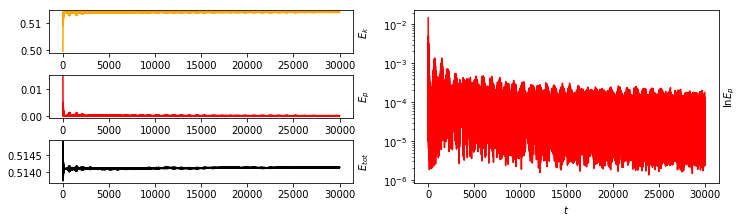

In [101]:
fig = plt.figure(figsize=(12, 3))

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.plot(t, dataek, color='orange')
ax1.set_ylabel(r'$E_k$')
ax1.yaxis.set_label_position("right")

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.plot(t, dataep, color='r')
ax2.set_ylabel(r'$E_p$')
ax2.yaxis.set_label_position("right")

ax3 = plt.subplot2grid((3, 2), (2, 0))
ax3.plot(t, dataet, color='black')
ax3.set_ylabel(r'$E_{tot}$')
ax3.yaxis.set_label_position("right")

axl2 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)
axl2.plot(t, dataep, color='r')
axl2.set_ylabel(r'$\ln E_p$')
axl2.set_yscale('log')
axl2.yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.1, top=0.9, hspace=.5, wspace=.2)
plt.xlabel(r'$t$')
plt.show()

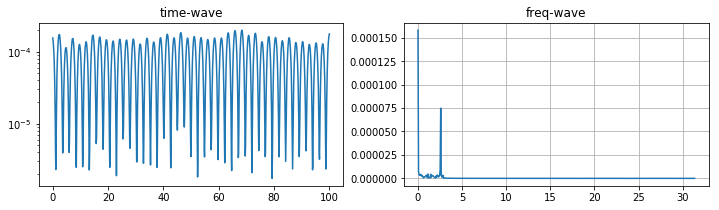

In [102]:
wave_start = max_steps-1000
wave_end = max_steps
wave_steps = wave_end - wave_start

t = np.linspace(0,wave_steps*dt,wave_steps)
yy = dataep[wave_start:wave_end]
n = wave_steps

def PlotWaveFreq(t,y):
    n = t.size
    y_k = fftpack.fft(y)
    x_k = fftpack.fftfreq(len(y_k),dt)
    y_k_abs = np.abs(y_k)
    y_k_phi = np.angle(y_k)

    plt.figure(figsize=(12,3))
    ax1 = plt.subplot(121)
    ax1.plot(t,y)
    ax1.set_yscale('log')
    ax1.set_title('time-wave')
    ax2 = plt.subplot(122)
    ax2.plot(2*np.pi*x_k[0:n//2],2.0*y_k_abs[0:n//2]/n)
    ax2.set_title('freq-wave')
    ax2.grid()
    plt.show()

PlotWaveFreq(t,yy)

In [103]:
def pdf(data,data_bins):##统计分布函数
    f, edges = np.histogram(data, bins=data_bins, density=True)
    x = (edges[0:len(edges)-1]+edges[1:len(edges)])/2
    dx = edges[1]-edges[0]
    return f, x, dx
def pdf2d(x,y,datax_bins,datay_bins):
    f,xedges,yedges = np.histogram2d(x,y,bins=[datax_bins,datay_bins],density=True)
    x = (xedges[0:len(xedges)-1]+xedges[1:len(xedges)])/2
    y = (yedges[0:len(yedges)-1]+yedges[1:len(yedges)])/2
    dx = xedges[1]-xedges[0]
    dy = yedges[1]-yedges[0]
    return f,x,y,dx,dy
def fm(v, t):
    r = np.sqrt(1./(2.*np.pi*t))*np.exp(-v**2/(2*t))
    return r
def fk(v, t, kappa):
    if(kappa == 0):
        r = fm(v, t)
    else:
        r = np.sqrt(m/(2.*np.pi*t*kappa)) * sp.gamma(kappa+1.5) / \
            sp.gamma(kappa+1) * (1 + m*v**2 / kappa / 2 / t) ** (-kappa-1.5)
    return r
def ue(x):
    r = 1.+uae*np.cos(2.*np.pi*x/L)
    return r
def ui(x):
    r = 1.+uai*np.cos(2.*np.pi*x/L)
    return r

### 初始分布函数fx fv

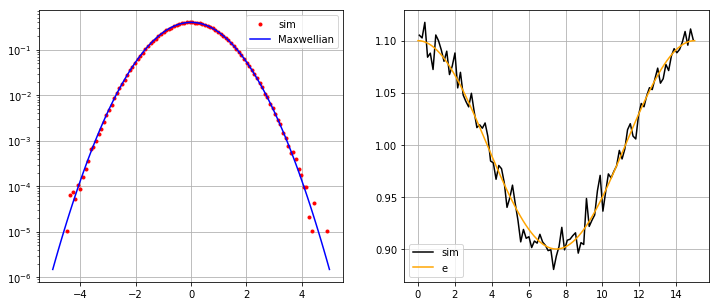

In [104]:
#initial VDF
fv0,v_fv0,dv_fv0 = pdf(vdata[0],nv)
fx0,x_fx0,dx_fx0 = pdf(xdata[0],nx)

fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(v_fv0,fv0,'.',color='r',label='sim')
ax1.plot(v,fm(v,tem),color='blue',label='Maxwellian')
ax1.set_yscale('log')

ax2.plot(x_fx0,fx0*L,'-',color='black',label='sim')
ax2.plot(x,ue(x),color='orange',label='e')

ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

### 末态分布函数

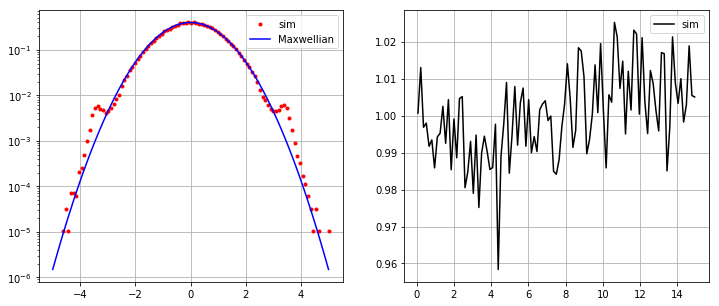

In [105]:
#final VDF
fv,v_fv,dv_fv=pdf(vdata[data_num-1],nv)
fx,x_fx,dx_fx=pdf(xdata[data_num-1],nx)

fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

ax1.plot(v_fv,fv,'.',color='r',label='sim')
ax1.plot(v,fm(v,tem),color='blue',label='Maxwellian')
ax1.set_yscale('log')

ax2.plot(x_fx,fx*L,color='black',label='sim')

ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

## 末态相图

In [106]:
data_num = 200

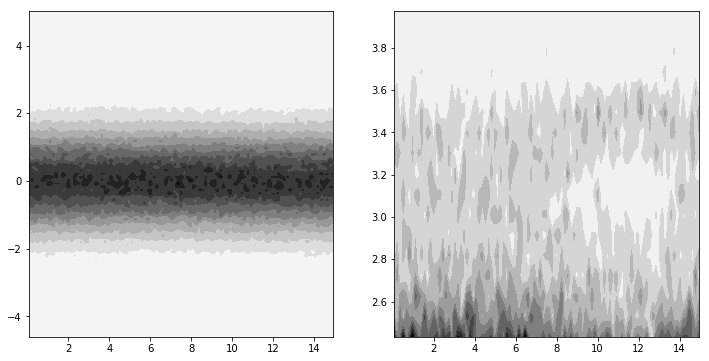

In [107]:
#概率相图
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))
Z,x_Z,v_Z,dx_Z,dv_Z = pdf2d(xdata[data_num-1],vdata[data_num-1],nx,nv)
V, X = np.meshgrid(v_Z, x_Z)
ax1.contourf(X,V,Z,levels=10,cmap='binary')
v_plot_mean=v_p
v_plot_shift=0.8
v_plot_min = int((v_plot_mean-v_plot_shift+vmax)/dv)
v_plot_max = int((v_plot_mean+v_plot_shift+vmax)/dv)
ax2.contourf(X[:,v_plot_min:v_plot_max],V[:,v_plot_min:v_plot_max],Z[:,v_plot_min:v_plot_max],levels=10,cmap='binary')
plt.show()

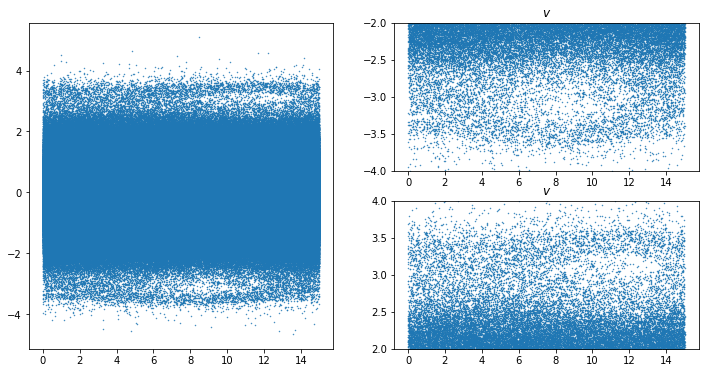

In [108]:
fig = plt.figure(figsize=(12,6))

ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 1))

ax1.scatter(xdata[data_num-1],vdata[data_num-1],s=0.2)
ax2.scatter(xdata[data_num-1],vdata[data_num-1],s=0.2)
ax2.set_ylim(-4,-2)
ax2.set_title(r'$v~-v_p$')
ax3.scatter(xdata[data_num-1],vdata[data_num-1],s=0.2)
ax3.set_ylim(2,4)
ax3.set_title(r'$v~v_p$')

plt.show()

## 动画显示

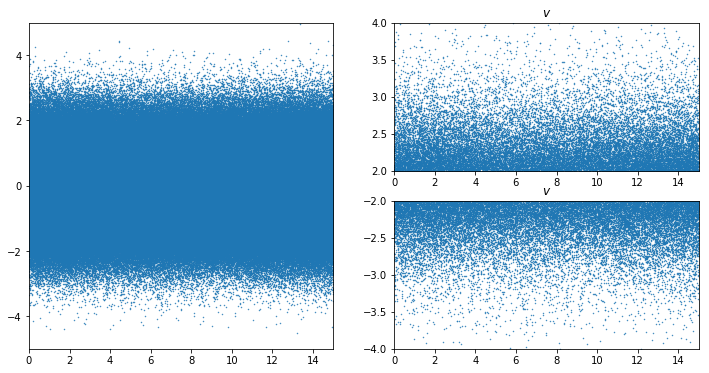

In [113]:
fig = plt.figure(figsize=(12,6))

ax1 = plt.subplot2grid((2, 2), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 1))

x_ani,v_ani=[],[]

xv1=ax1.scatter(x_ani,v_ani,s=0.2)
ax1.set_xlim(0,L)
ax1.set_ylim(-vmax,vmax)

xv2=ax2.scatter(x_ani,v_ani,s=0.2)
ax2.set_xlim(0,L)
ax2.set_ylim(2,4)
ax2.set_title(r'$v~-v_p$')

xv3=ax3.scatter(x_ani,v_ani,s=0.2)
ax3.set_xlim(0,L)
ax3.set_ylim(-4,-2)
ax3.set_title(r'$v~v_p$')

def update(frame):
    x_ani = xdata[frame]
    v_ani = vdata[frame]
    xv_ani = np.vstack((x_ani,v_ani)).T
    xv1.set_offsets(xv_ani)
    xv2.set_offsets(xv_ani)
    xv3.set_offsets(xv_ani)
    return xv1,xv2
ani = FuncAnimation(fig,update,frames=np.arange(0,data_num), interval = 500, repeat=False, blit = False)

In [114]:
my_writer = FFMpegFileWriter(fps=6,bitrate=-1,codec="libx264")
ani.save('./bgk-mode-pic.mp4', dpi=160, writer=my_writer)